# Oceanography - Data Conversion

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bacalhau-project/examples/blob/main/data-engineering/oceanography-conversion/index.ipynb)
[![Open In Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/bacalhau-project/examples/HEAD?labpath=data-engineering/oceanography-conversion/index.ipynb)

The Surface Ocean CO₂ Atlas (SOCAT) contains measurements of the [fugacity](https://en.wikipedia.org/wiki/Fugacity) of CO2 in seawater around the globe. But to calculate how much carbon the ocean is taking up from the atmosphere, these measurements need to be converted to the partial pressure of CO2. We will convert the units by combining measurements of the surface temperature and fugacity.  Python libraries (xarray, pandas, numpy) and the pyseaflux package facilitate this process.

References:
- https://www.socat.info/
- https://seaflux.readthedocs.io/en/latest/api.html?highlight=fCO2_to_pCO2#pyseaflux.fco2_pco2_conversion.fCO2_to_pCO2
- https://github.com/lgloege/bacalhau_socat_test/blob/main/main.py
- https://github.com/wesfloyd/bacalhau_socat_test

### Goal

The goal of this notebook is to investigate the data and convert dockerize the workload so that it can be executed on the Bacalhau network, to take advantage of the distributed storage and compute resources.

### Prerequisites

This example requires Docker. If you don't have Docker installed, you can install it from [here](https://docs.docker.com/install/). Docker commands will not work on hosted notebooks like Google Colab, but the Bacalhau commands will.

Make sure you have the latest `bacalhau` client installed by following the [getting started instructions](../../../getting-started/installation)

## The Data

The raw data is available on the [SOCAT website](https://www.socat.info/). We will use the [SOCATv2021](https://www.socat.info/index.php/version-2021/) dataset in the "Gridded" format to perform this calculation. First, let's take a quick look at some data:

In [ ]:
!command -v docker >/dev/null 2>&1 || { echo >&2 "I require docker but it's not installed.  Aborting."; exit 1; }

In [4]:
!(export BACALHAU_INSTALL_DIR=.; curl -sL https://get.bacalhau.org/install.sh | bash)
path=!echo $PATH
%env PATH=./:{path[0]}

Your system is linux_amd64
No BACALHAU detected. Installing fresh BACALHAU CLI...
Getting the latest BACALHAU CLI...
Installing v0.2.4 BACALHAU CLI...
Verified OK
Extracting tarball ...
NOT verifying Bin
bacalhau installed into . successfully.
Client Version: v0.2.4
Server Version: v0.2.4
env: PATH=./:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


In [1]:
%%bash
mkdir -p inputs
curl --output ./inputs/SOCATv2022_tracks_gridded_monthly.nc.zip https://www.socat.info/socat_files/v2022/SOCATv2022_tracks_gridded_monthly.nc.zip
curl --output ./inputs/sst.mnmean.nc https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2/sst.mnmean.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35.5M  100 35.5M    0     0  13.1M      0  0:00:02  0:00:02 --:--:-- 13.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60.4M  100 60.4M    0     0  50.5M      0  0:00:01  0:00:01 --:--:-- 50.5M


Next let's write the requirements.txt and install the dependencies. This file will also be used by the Dockerfile to install the dependencies.

In [2]:
%%writefile requirements.txt
Bottleneck==1.3.5
dask==2022.2.0
fsspec==2022.5.0
netCDF4==1.6.0
numpy==1.21.6
pandas==1.3.5
pip==22.1.2
pyseaflux==2.2.1
scipy==1.7.3
xarray==0.20.2
zarr>=2.0.0

Writing requirements.txt


In [3]:
%%bash
pip install -r requirements.txt > /dev/null

In [1]:
import fsspec # for reading remote files
import xarray as xr
with fsspec.open("./inputs/SOCATv2022_tracks_gridded_monthly.nc.zip", compression='zip') as fp:
    ds = xr.open_dataset(fp)
ds.info()

xarray.Dataset {
dimensions:
	xlon = 360 ;
	ylat = 180 ;
	tmnth = 624 ;
	bnds = 2 ;

variables:
	float64 xlon(xlon) ;
		xlon:units = degrees_east ;
		xlon:point_spacing = even ;
		xlon:axis = X ;
		xlon:modulo = 360.0 ;
		xlon:standard_name = longitude ;
	float64 ylat(ylat) ;
		ylat:units = degrees_north ;
		ylat:point_spacing = even ;
		ylat:axis = Y ;
		ylat:standard_name = latitude ;
	datetime64[ns] tmnth(tmnth) ;
		tmnth:axis = T ;
		tmnth:bounds = tmnth_bnds ;
		tmnth:time_origin = 01-JAN-1970 ;
		tmnth:standard_name = time ;
	datetime64[ns] tmnth_bnds(tmnth, bnds) ;
	float64 count_ncruise(tmnth, ylat, xlon) ;
		count_ncruise:long_name = Number of cruises ;
		count_ncruise:units = count ;
		count_ncruise:history = From SOCAT_ABCD_data_for_gridding ;
		count_ncruise:summary = Number of datasets containing observations in the grid cell ;
	float64 fco2_count_nobs(tmnth, ylat, xlon) ;
		fco2_count_nobs:long_name = Number of fco2 obs ;
		fco2_count_nobs:units = count ;
		fco2_count_nob

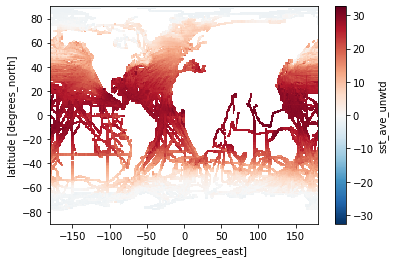

In [ ]:
time_slice = slice("2010", "2020") # select a decade
res = ds['sst_ave_unwtd'].sel(tmnth=time_slice).mean(dim='tmnth') # average over time
res.plot() # plot the result


We can see that the dataset contains lat-long coordinates, the date, and a series of seawater measurements. Above you can see a plot of the average surface sea temperature (sst) between 2010-2020, where recording buoys and boats have travelled.

## The Task - Large Scale Data Conversion

The goal of this notebook is to convert the data from fugacity of CO2 (fCO2) to partial pressure of CO2 (pCO2). This is a common task in oceanography, and is performed by combining the measurements of the surface temperature and fugacity. The conversion is performed by the [pyseaflux](https://seaflux.readthedocs.io/en/latest/api.html?highlight=fCO2_to_pCO2#pyseaflux.fco2_pco2_conversion.fCO2_to_pCO2) package.

To execute this workload on the Bacalhau network we need to perform three steps:

1. Upload the data to IPFS
2. Create a docker image with the code and dependencies
3. Run the docker image on the Bacalhau network using the IPFS data

### Upload the Data to IPFS

The first step is to upload the data to IPFS. The simplest way to do this is to use a third party service to "pin" data to the IPFS network, to ensure that the data exists and is available. To do this you need an account with a pinning service like [web3.storage](https://web3.storage/) or [Pinata](https://pinata.cloud/). Once registered you can use their UI or API or SDKs to upload files.

For the purposes of this example I:
1. Downloaded the latest monthly data from the [SOCAT website](https://www.socat.info/)
2. Downloaded the latest long-term global sea surface temperature data from [NOAA](https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2/sst.mnmean.nc) - information about that dataset can be found [here](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html).
3. Pinned the data to IPFS

This resulted in the IPFS CID of `bafybeidunikexxu5qtuwc7eosjpuw6a75lxo7j5ezf3zurv52vbrmqwf6y`.

<!-- TODO: Add link to notebook showing people how to upload data to IPFS -->

### Create a Docker Image to Process the Data

Next we will create the docker image that will process the data. The docker image will contain the code and dependencies needed to perform the conversion. This code originated with [lgloege](https://github.com/lgloege/bacalhau_socat_test) via [wesfloyd](https://github.com/wesfloyd/bacalhau_socat_test/). Thank you! 🤗

:::tip
For more information about working with custom containers, see the [custom containers example](../../workload-onboarding/custom-containers/).
:::

The key thing to watch out for here is the paths to the data. I'm using the default bacalhau output directory `/outputs` to write my data to. And the input data is mounted to the `/inputs` directory. But as you will see in a moment, web3.storage has added another `input` directory that we need to account for.

In [ ]:
%%writefile main.py
import fsspec
import xarray as xr
import pandas as pd
import numpy as np
import pyseaflux


def lon_360_to_180(ds=None, lonVar=None):
    lonVar = "lon" if lonVar is None else lonVar
    return (ds.assign_coords({lonVar: (((ds[lonVar] + 180) % 360) - 180)})
            .sortby(lonVar)
            .astype(dtype='float32', order='C'))


def center_dates(ds):
    # start and end date
    start_date = str(ds.time[0].dt.strftime('%Y-%m').values)
    end_date = str(ds.time[-1].dt.strftime('%Y-%m').values)

    # monthly dates centered on 15th of each month
    dates = pd.date_range(start=f'{start_date}-01T00:00:00.000000000',
                          end=f'{end_date}-01T00:00:00.000000000',
                          freq='MS') + np.timedelta64(14, 'D')

    return ds.assign(time=dates)


def get_and_process_sst(url=None):
    # get noaa sst
    if url is None:
        url = ("/inputs/sst.mnmean.nc")

    with fsspec.open(url) as fp:
        ds = xr.open_dataset(fp)
        ds = lon_360_to_180(ds)
        ds = center_dates(ds)
        return ds


def get_and_process_socat(url=None):
    if url is None:
        url = ("/inputs/SOCATv2022_tracks_gridded_monthly.nc.zip")

    with fsspec.open(url, compression='zip') as fp:
        ds = xr.open_dataset(fp)
        ds = ds.rename({"xlon": "lon", "ylat": "lat", "tmnth": "time"})
        ds = center_dates(ds)
        return ds


def main():
    print("Load SST and SOCAT data")
    ds_sst = get_and_process_sst()
    ds_socat = get_and_process_socat()

    print("Merge datasets together")
    time_slice = slice("1981-12", "2022-05")
    ds_out = xr.merge([ds_sst['sst'].sel(time=time_slice),
                       ds_socat['fco2_ave_unwtd'].sel(time=time_slice)])

    print("Calculate pco2 from fco2")
    ds_out['pco2_ave_unwtd'] = xr.apply_ufunc(
        pyseaflux.fCO2_to_pCO2,
        ds_out['fco2_ave_unwtd'],
        ds_out['sst'])

    print("Add metadata")
    ds_out['pco2_ave_unwtd'].attrs['units'] = 'uatm'
    ds_out['pco2_ave_unwtd'].attrs['notes'] = ("calculated using" +
                                               "NOAA OI SST V2" +
                                               "and pyseaflux package")

    print("Save data")
    ds_out.to_zarr("/processed.zarr")
    import shutil
    shutil.make_archive("/outputs/processed.zarr", 'zip', "/processed.zarr")
    print("Zarr file written to disk, job completed successfully")

if __name__ == "__main__":
    main()

Overwriting main.py


In [ ]:
%%writefile Dockerfile
FROM python:slim

RUN apt-get update && apt-get -y upgrade \
    && apt-get install -y --no-install-recommends \
    g++ \
    && rm -rf /var/lib/apt/lists/*

WORKDIR /project

COPY ./requirements.txt /project

RUN pip3 install -r requirements.txt

COPY ./main.py /project

CMD ["python","main.py"]

Overwriting Dockerfile


In [ ]:
%%bash
# docker buildx build --platform linux/amd64,linux/arm64 --push -t ghcr.io/bacalhau-project/examples/socat:0.0.11 .

### Test the Container Locally

Before we upload the container to the Bacalhau network, we should test it locally to make sure it works.

In [ ]:
%%bash
docker run \
	-v $(pwd)/inputs:/inputs \
	-v $(pwd)/outputs:/outputs \
	ghcr.io/bacalhau-project/examples/socat:0.0.11

Zarr file written to disk, job completed successfully


### Run a Bacalhau Job

Now that we have the data in IPFS and the docker image pushed, we can run a job on the Bacalhau network.

I find it useful to first run a simple test with a known working container to ensure the data is located in the place I expect, because some storage providers add their own opinions. E.g. web3.storage wraps the directory uploads in a top level directory.

In [ ]:
%%bash
rm -rf stdout stderr volumes shards
bacalhau docker run \
        --download \
        --inputs bafybeidunikexxu5qtuwc7eosjpuw6a75lxo7j5ezf3zurv52vbrmqwf6y \
        ubuntu -- ls /inputs

d26d6c9a-ede3-47fd-9c2c-9be272eaf4f5

SOCATv2022_tracks_gridded_monthly.nc.zip
sst.mnmean.nc



16:34:34.748 | INF ipfs/downloader.go:115 > Found 1 result shards, downloading to temporary folder.
16:34:37.741 | INF ipfs/downloader.go:195 > Combining shard from output volume 'outputs' to final location: '/Users/phil/source/bacalhau-project/examples/data-engineering/oceanography-conversion'


Then I like to run a simple test with my custom container ...

In [ ]:
%%bash
rm -rf stdout stderr volumes shards
bacalhau docker run \
	--inputs bafybeidunikexxu5qtuwc7eosjpuw6a75lxo7j5ezf3zurv52vbrmqwf6y \
	--download \
	ghcr.io/bacalhau-project/examples/socat:0.0.11 -- ls -la /inputs/

8cb67fbe-6574-4597-95df-006f5aaa5f88

total 98296
drwxr-xr-x 2 root root     4096 Sep 23 14:15 .
drwxr-xr-x 1 root root     4096 Sep 26 15:34 ..
-rw-r--r-- 1 root root 37249557 Sep 23 14:15 SOCATv2022_tracks_gridded_monthly.nc.zip
-rw-r--r-- 1 root root 63390820 Sep 23 14:15 sst.mnmean.nc



16:35:02.943 | INF ipfs/downloader.go:115 > Found 1 result shards, downloading to temporary folder.
16:35:05.635 | INF ipfs/downloader.go:195 > Combining shard from output volume 'outputs' to final location: '/Users/phil/source/bacalhau-project/examples/data-engineering/oceanography-conversion'


And finally let's run the full job. This time I will not download the data immediately, because the job takes around 100s. And it takes another few minutes to download the results. The commands are below, but you will need to wait until the job completes before they work.

In [ ]:
%%bash  --out job_id
bacalhau docker run \
        --inputs bafybeidunikexxu5qtuwc7eosjpuw6a75lxo7j5ezf3zurv52vbrmqwf6y \
        --wait \
        ghcr.io/bacalhau-project/examples/socat:0.0.11 -- python main.py

In [2]:
%env JOB_ID={job_id}

env: JOB_ID=8e162098-f9bc-4733-8c98-c2e89ebefc5e


## Get Results

Now let's download and display the result from the results directory. We can use the `bacalhau results` command to download the results from the output data volume. The `--output-dir` argument specifies the directory to download the results to.

In [7]:
%%bash
rm -rf results
mkdir -p ./results # Temporary directory to store the results
bacalhau get --output-dir ./results ${JOB_ID} # Download the results

Process is interrupted.


In [ ]:
%%bash
cat ./results/stdout

Load SST and SOCAT data
Merge datasets together
Calculate pco2 from fco2
Add metadata
Save data
Zarr file written to disk, job completed successfully


In [ ]:
%%bash
ls ./results/volumes/outputs

processed.zarr.zip


In [9]:
import shutil
shutil.unpack_archive("./results/volumes/outputs/processed.zarr.zip", "./results/volumes/outputs/")

In [10]:
import xarray as xr
ds = xr.open_dataset("./results/volumes/outputs/", engine='zarr')
ds.info()

xarray.Dataset {
dimensions:
	time = 486 ;
	lat = 180 ;
	lon = 360 ;

variables:
	float32 fco2_ave_unwtd(time, lat, lon) ;
		fco2_ave_unwtd:history = From SOCAT_ABCD_data_for_gridding ;
		fco2_ave_unwtd:long_name = fCO2 mean - unweighted all obs ;
		fco2_ave_unwtd:summary = Arithmetic mean of all fco2 recomputed values found in the grid cell. ;
		fco2_ave_unwtd:units = uatm ;
	float32 lat(lat) ;
	float32 lon(lon) ;
	float32 pco2_ave_unwtd(time, lat, lon) ;
		pco2_ave_unwtd:notes = calculated usingNOAA OI SST V2and pyseaflux package ;
		pco2_ave_unwtd:units = uatm ;
	float32 sst(time, lat, lon) ;
		sst:actual_range = [-1.7999995946884155, 35.56861877441406] ;
		sst:cell_methods = time: mean (monthly from weekly values interpolated to daily) ;
		sst:dataset = NOAA Optimum Interpolation (OI) SST V2 ;
		sst:level_desc = Surface ;
		sst:long_name = Monthly Mean of Sea Surface Temperature ;
		sst:parent_stat = Weekly Mean ;
		sst:precision = 2 ;
		sst:standard_name = sea_surface_temperature 

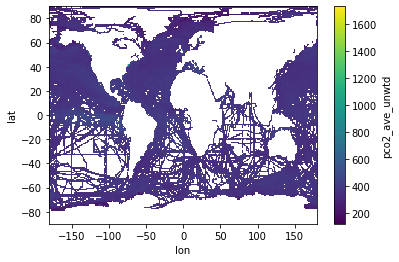

In [ ]:
ds['pco2_ave_unwtd'].mean(dim='time').plot()